In [49]:
'''This diagonalizes the Hamiltonian matrix for a hydrogen-like spin system and 
gives various useful ESR related plots and values. Scroll down past the functions
section to get to the bit of the program where you tell it what to do'''
################################################
import numpy as np
from scipy.constants import*
import matplotlib.pyplot as plt
import seaborn as sns
from fractions import Fraction
from colour import Color
from matplotlib.collections import LineCollection
from time import time
import sys
################################################
#Functions
#Write 1/2 integer as fraction
def h_int(n):
    fraction = str(int(n*2))+"/2"
    return (fraction)


#Coefficient when raising operator J+ is applied
def alpha(mz,J):
    alpha = (J*(J+1)-mz*(mz+1))**0.5
    return (alpha)

#Multiplicity of J
def M(J):
    M = int(2*J+1)
    return (M)

#Creates N dimensional identity matrix
def identity (N):

    I = np.zeros((N,N))
    for n in range (N):
        for m in range(N):
            if n==m:
                I[n,m] = 1
    return (I)
            
#Angular momentum operators for angular momentum J
def ang_mo_op(J):
    N=int(2*J+1)
    
    J_plus = np.zeros((N,N))
    J_minus = np.zeros((N,N))
    Jz = np.zeros((N,N))
    
    for n in range (N):
        for m in range(N):
            if n==m+1:
                J_plus[n,m] = alpha(J-n,J)
            if n==m-1:
                J_minus[n,m] = alpha(J-m,J)
            if n==m:
                Jz[n,m] = J-n
    
    Jx = 0.5*(J_plus+J_minus)
    Jy = -0.5*1j*(J_plus-J_minus)
    return (Jx,Jy,Jz)
    
#Electron and nuclear Zeeman terms
def Zeeman(gI,gS,B,Ixb,Iyb,Izb,Sxb,Syb,Szb):
    ub = physical_constants["Bohr magneton"][0]
    un = physical_constants["nuclear magneton"][0]
    H = un*gI*((Ixb*B[0]+Iyb*B[1]+Izb*B[2]))+ub*gS*(Sxb*B[0]+Syb*B[1]+Szb*B[2])
    return (H)

#Hyperfine coupling term    
def HFC(A,Ix,Iy,Iz,Sx,Sy,Sz):
    H = h*A*(prod_IS(Ix,Sx)+prod_IS(Iy,Sy)+prod_IS(Iz,Sz))
    return (H)

#Multiply compenents by identities to enlarge a 2x2 matrix Sx to dimension (2MI)x(2MI)
def enlarge_S(MI,Sx):
    A = (identity(MI)*Sx[0,0])
    B = (identity(MI)*Sx[0,1])
    C = (identity(MI)*Sx[1,0])
    D = (identity(MI)*Sx[1,1])
    Sxb = np.bmat('A,B;C,D')
    return (Sxb)
    
#Enlarges an MIxMI matrix Ix to (2MI)x(2MI)
def enlarge_I(Ix,MI):
    Ixb=np.bmat([[Ix,np.zeros((MI,MI))],[np.zeros((MI,MI)),Ix]])
    return (Ixb)
    
#Kronecker product of a 2x2 matrix Sx with an MIxMI matrix Ix
def prod_IS(Ix,Sx):
    A = (Ix*Sx[0,0])
    B = (Ix*Sx[0,1])
    C = (Ix*Sx[1,0])
    D = (Ix*Sx[1,1])
    IxSx = np.bmat('A,B;C,D')
    return (IxSx)
    
#Calculate all eigenenergies as a function of B field
def calc_eigenenergies(species,Bmax,Bmin = 0,points = 1000):
    start_time = time()
    #print('calculating eigenenergies...')
    #print(Bmin,Bmax)
    MI = M(species[0])
    H = []
    E = []
    B_sweep = []
    eigenvectors = []

    (Ix,Iy,Iz) = ang_mo_op(species[0])
    (Ixb,Iyb,Izb) = (enlarge_I(Ix,MI),enlarge_I(Iy,MI),enlarge_I(Iz,MI))
    
    (Sx,Sy,Sz) = ang_mo_op(species[1])
    (Sxb,Syb,Szb) = (enlarge_S(MI,Sx),enlarge_S(MI,Sy),enlarge_S(MI,Sz))

    for n in range(MI*2):
        #PrintStatic(str(n))
        E.append([])
    
    for n in range (points):
        PrintStatic(str(n))
        B=[0,0,Bmin+(Bmax-Bmin)/points*n]
        B_sweep.append(B[2])
        H.append(HFC(species[4],Ix,Iy,Iz,Sx,Sy,Sz)+Zeeman(species[3],species[2],B,Ixb,Iyb,Izb,Sxb,Syb,Szb))
        
        (eigval,eigvec)=(np.linalg.eig(H[n]))
        eigenvectors.append([eigvec,eigval])
        for n in range(MI*2):
            E[n].append(np.sort(np.real(eigval))[n]/h/1E9)
    #print('done in %.2fs'%(time()-start_time))
    return (B_sweep,E,eigenvectors)

def FGR_transitions(eigvec,species,B_drive = [1,0,0]):
    MI = M(species[0])
    (Ix,Iy,Iz) = ang_mo_op(species[0])
    (Ixb,Iyb,Izb) = (enlarge_I(Ix,MI),enlarge_I(Iy,MI),enlarge_I(Iz,MI))
    
    (Sx,Sy,Sz) = ang_mo_op(species[1])
    (Sxb,Syb,Szb) = (enlarge_S(MI,Sx),enlarge_S(MI,Sy),enlarge_S(MI,Sz))
    
    Es,gammas,nm = [],[],[]
    
    H_drive = Zeeman(species[3],species[2],B_drive,Ixb,Iyb,Izb,Sxb,Syb,Szb)
    length = len(np.squeeze(np.asarray(eigvec[0][0,:])))
    for n in range(length):
        i = np.squeeze(np.asarray(eigvec[0][:,n]))
        for m in range(n+1,len(i)):
            # print('{}, {}'.format(n,m))
            f = np.squeeze(np.asarray(eigvec[0][:,m]))
            gamma = 1e24*np.abs(np.matmul(f,np.squeeze(np.asarray(np.matmul(H_drive,i)))))
            
            
            if gamma > 0 :
                Ef = np.real(eigvec[1][m])/h/1E9
                Ei = np.real(eigvec[1][n])/h/1E9
                # import pdb; pdb.set_trace()
                E=(np.abs(Ef-Ei))
                Es.append([E,gamma,Ef,Ei])
                #print(Ef,Ei)
        Es = (np.array(Es))
    #print(Es[:,1].min())
    Es = Es[Es[:,0].argsort()]
    return(Es[:,0],Es[:,1],Es[:,2],Es[:,3])            

def plot_transitions(B_sweep,eigenvectors,species,B_drive = [1,0,0],cmap = "Blues"):    
    #print(species)
    start_time = time()
    print('calculating and plotting transitions...')
    for n in range(len(B_sweep)):
        PrintStatic(str(n))
        E,g,Ef,Ei = FGR_transitions(eigenvectors[n],species,B_drive=B_drive)
        
        if n ==0: Es,gs,Efs,Eis = E,g,Ef,Ei
        else: Es,gs,Efs,Eis = np.column_stack((Es, E)),np.column_stack((gs, g)),np.column_stack((Efs, Ef)),np.column_stack((Eis, Ei))
    
#     for n in range (np.shape(gs)[1]-1): 
#         plot_multicoloured_line(1000*np.array(B_sweep),Es[n],gs[n]/gs.max(),cmap = cmap)
    print(gs)
    plot_multicoloured_line(1000*np.array(B_sweep),Es[0],gs[0]/gs.max(),cmap = cmap)
    plot_multicoloured_line(1000*np.array(B_sweep),Es[1],gs[1]/gs.max(),cmap = cmap)
    plot_multicoloured_line(1000*np.array(B_sweep),Es[2],gs[2]/gs.max(),cmap = cmap)
    plot_multicoloured_line(1000*np.array(B_sweep),Es[3],gs[3]/gs.max(),cmap = cmap)
    #print(gs[10])
    #plt.plot(1000*np.array(B_sweep),gs[n])#
    plt.ylabel('Transition frequency(GHz)')
    plt.xlabel('Field(mT)')  
    plt.xlim(1000*np.array(B_sweep).min(), 1000*np.array(B_sweep).max())
    plt.tight_layout()
    print('done in %.2fs'%(time()-start_time))
    return(Es,gs,Efs,Eis)              
       
def PrintStatic(s):
    sys.stdout.write(s + " " * (78 - len(s)) + "\r")
    
def plot_multicoloured_line(x,y,c,cmap = "Blues"):
    # set up a list of (x,y) points
    points = np.array([x,y]).transpose().reshape(-1,1,2)
    #print (points.shape)  # Out: (len(x),1,2)
    
    # set up a list of segments
    segs = np.concatenate([points[:-1],points[1:]],axis=1)
    #print (segs.shape)  # Out: ( len(x)-1, 2, 2 )
                    # see what we've done here -- we've mapped our (x,y)
                    # points to an array of segment start/end coordinates.
                    # segs[i,0,:] == segs[i-1,1,:]
    
    # make the collection of segments
    lc = LineCollection(segs, cmap=plt.get_cmap(cmap),alpha = 0.6)
    lc.set_array(c) # color the segments by our parameter
    
    sns.set(font_scale=1.4, style='ticks')
    sns.set_style({"xtick.direction": "in","ytick.direction": "in",'ytick.right': True,'xtick.top': True})
    # plot the collection
    plt.gca().add_collection(lc) # add the collection to the plot


################################################
#Put system parameters here
Bmax = 1.0

#species   = [I  ,J  ,gS     ,gI    ,A(Hz)    ]
bismuth    = [9/2,1/2,2.00032,0.9135,1475.17E6]
phosphorus = [1/2,1/2,1.9985 ,0.9135,117.53E6 ]

species = phosphorus 

B_sweep,E,eigenvectors = calc_eigenenergies(species,1,Bmin = 0, points = 10)

Ezs,gzs,Efzs,Eizs = plot_transitions(B_sweep,eigenvectors,species,B_drive = [1,0,0],cmap = "OrRd")
plt.show()

calculating and plotting transitions...


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [46]:
Es

NameError: name 'Es' is not defined

In [20]:
Ezs,gzs,Efzs,Eizs = plot_transitions(B_sweep,eigenvectors,species,B_drive = [0,0,1],cmap = "OrRd")
plt.ylim(0,max(Ezs[0]))
plt.show()

calculating and plotting transitions...


AttributeError: 'numpy.ndarray' object has no attribute 'append'

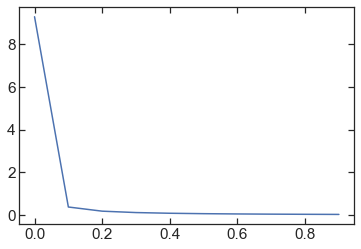

In [10]:
plt.plot(B_sweep,gzs[0])